In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spo
import matplotlib.animation as animation 
import seaborn as sns
sns.set()



In [2]:
def sig(x, args = (1,1,6,0)):
    if len(args) != 4:
        raise Exception('Dimension mismatch, there should be 4 parameters', len(args), 'have been passed')
    a = args[0] 
    b = args[1] 
    c = args[2] 
    d = args[3]
    out = np.array(a/(1+np.exp(-b*(x-c)))+d)
    return out

In [3]:
# I program my own fitting function because when using spo.curve_fit I often get an error -> does not converge
def loss(Ydat,Y):
    if Ydat.shape != Y.shape:
        raise Exception('Dimension mismatch, Ydat and Y should have the same length. They respectively have length ',
                       Ydat.shape,' and ',Y.shape)
        return 0
    Ydat = np.array(Ydat)
    Y=np.array(Y)
    return ((Y-Ydat)**2).mean()

def curve_fit(fun, Xdat,Ydat, x0):
    n=len(x0)
    diag=np.diag([1 for i in range(n)])
    return spo.minimize(lambda arg: loss(Ydat,fun(Xdat, arg)), x0 = x0, method='Powell', options={'xtol':0.01,'direc':0.1*diag})

In [4]:
x = np.linspace(-6,6,100)

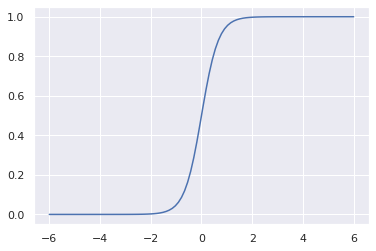

In [5]:
plt.plot(x, sig(x, [1,3,0,0]))

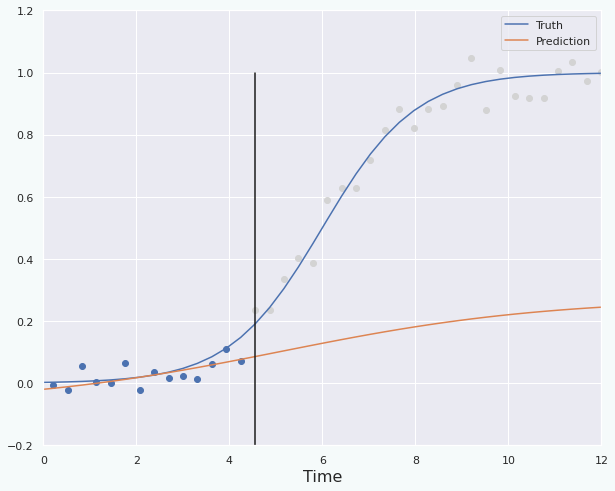

In [6]:
std = 0.05
x = np.linspace(-0.1,12,40)
ydat=sig(x)+np.random.normal(scale=std,size=len(x))


fig = plt.figure(figsize=(10,8))
plt.axes(xlim=(0, 12), ylim=(-0.2, 1.2))
length = 15
plt.scatter(x[:length],ydat[:length], c='b')
plt.scatter(x[length:], ydat[length:], c='lightgrey')
plt.plot(x, sig(x), label = "Truth")
fit_param = curve_fit(sig, x[:length], ydat[:length], [1,1,0,0]) #infer the parameter of the model by fitting the curve the k first points (k=length)
plt.plot(x,sig(x,fit_param['x']), label = "Prediction")
plt.plot([x[length],x[length]], [-0.2,1], c='k')
plt.xlabel('Time', fontsize =16)
plt.legend(loc = 'best')
fig.patch.set_facecolor('#f5fafa')
plt.savefig('basic_plot.png')

# Animation

/home/jeremy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


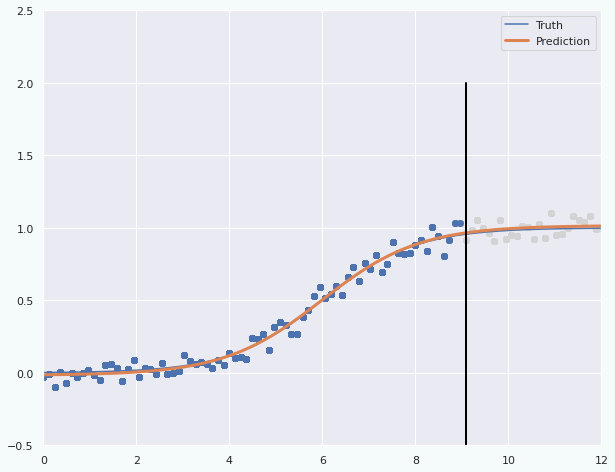

In [7]:
fig = plt.figure(figsize=(10,8))
fig.patch.set_facecolor('#f5fafa')
ax = plt.axes(xlim=(0, 12), ylim=(-0.5, 2.5))
truth = ax.plot(x,sig(x), label='Truth')
line, = ax.plot([], [], lw=3, label='Prediction')
line2, = ax.plot([],[],lw=2,color='black')


std=0.05
nb_points = 100
x = np.linspace(0,12,nb_points)
ydat=sig(x)+np.random.normal(scale=std,size=len(x))

def init():    
    line.set_data([], [])
    plt.legend(loc='best')
    return line,

def animate(i):
    length = i+16
    x = np.linspace(0,12,nb_points)
    plt.scatter(x[:length],ydat[:length], c='b')
    plt.scatter(x[length:], ydat[length:], c='lightgrey')
    fit_param = curve_fit(sig, x[:length], ydat[:length],[1,1,0,0])
    y = sig(x,fit_param['x'])
    line.set_data(x, y)
    line2.set_data([x[length],x[length]], [-0.5,2])
    return line,


anim = animation.FuncAnimation(fig, animate, init_func=init, frames=60, interval=400, blit=True)

anim.save('sig_hard_fitting.gif', writer='imagemagick')

# Percentile interval with noise whose probability distribution is known

In [15]:
std = 0.05
nb_points = 50
x = np.linspace(0,12,nb_points)
ydat=sig(x)+np.random.normal(scale=std,size=len(x))

length = 20
fit_param = curve_fit(sig, x[:length], ydat[:length], [1,1,6,0]) 

#Monte Carlo simulation using the fit as a good approximation of the true sigmoid for x<length
std_est = np.sqrt(loss(ydat[:length],sig(x[:length],fit_param['x'])))       #estimates the std of the noise via the residuals
List_param = []
max_loop=1000
for i in range(max_loop):
    ysim = sig(x[:length],fit_param['x'])+np.random.normal(scale=std_est, size=length)
    fit_param_temp = curve_fit(sig, x[:length], ysim[:length], [1,1,0,0])
    List_param.append(fit_param_temp['x'])
    
#Find the curves that will drow the 95% interval
k1 = int(0.025 * max_loop)
k_med = int(0.5*max_loop)
k2 = int(0.975 * max_loop)
List_values_all_sigs = np.array([sig(x[length:],param) for param in List_param])
values_LMH = np.array([(np.partition(List_values_all_sigs[:,i],k1)[k1-1],
               np.partition(List_values_all_sigs[:,i],k_med)[k_med-1],
               np.partition(List_values_all_sigs[:,i],k2)[k2-1]) for i in range(len(x[length:]))])  #LMH stands for low median high

del List_values_all_sigs               #Free some memory by deleting this variable

/home/jeremy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


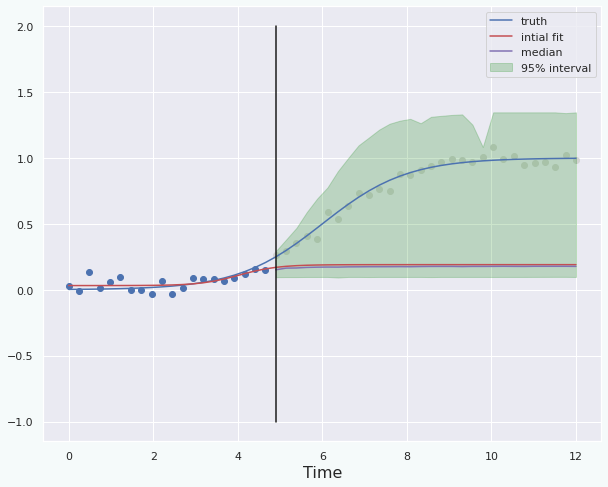

In [16]:
fig = plt.figure(figsize=(10,8))
fig.patch.set_facecolor('#f5fafa')
plt.scatter(x[:length], ydat[:length])
plt.scatter(x[length:], ydat[length:], c='lightgrey')
plt.plot(x, sig(x), label='truth')
plt.plot(x,sig(x, fit_param['x']),'r',label = 'intial fit')
plt.fill_between(x[length:],values_LMH[:,0],values_LMH[:,2],color='green',alpha=0.2, label='95% interval')
plt.plot(x[length:], values_LMH[:,1],c='m',label = 'median')
plt.plot([x[length],x[length]], [2,-1],'k')
plt.xlabel('Time', fontsize = 16)
plt.legend(loc = 'best')
plt.savefig('Percentile_known.png')

# Percentile interval with noise whose probability distribution is unknown

In [66]:
std = 0.05
x = np.linspace(0,12,100)
np.random.seed(0)
ydat=sig(x)+np.random.normal(scale=std,size=len(x))

length = 80
fit_param = curve_fit(sig, x[:length], ydat[:length], [1,1,6,0]) 


List_param = []
max_loop=1000
for i in range(max_loop):
    residues = np.random.choice(ydat[:length]-sig(x[:length],fit_param['x']),size=length)
    ysim = sig(x[:length],fit_param['x']) + residues
    fit_param_temp = curve_fit(sig, x[:length], ysim, [1,1,6,0])
    List_param.append(fit_param_temp['x'])

#Find the curves that will draw the 95% interval
k1 = int(0.025 * max_loop)
k_med = int(0.5*max_loop)
k2 = int(0.975 * max_loop)
List_values_all_sigs = np.array([sig(x[length:],param) for param in List_param])
values_LMH = np.array([(np.partition(List_values_all_sigs[:,i],k1)[k1-1],
               np.partition(List_values_all_sigs[:,i],k_med)[k_med-1],
               np.partition(List_values_all_sigs[:,i],k2)[k2-1]) for i in range(len(x[length:]))])  #LMH stands for low median high



del List_values_all_sigs               #Free some memory by deleting this variable

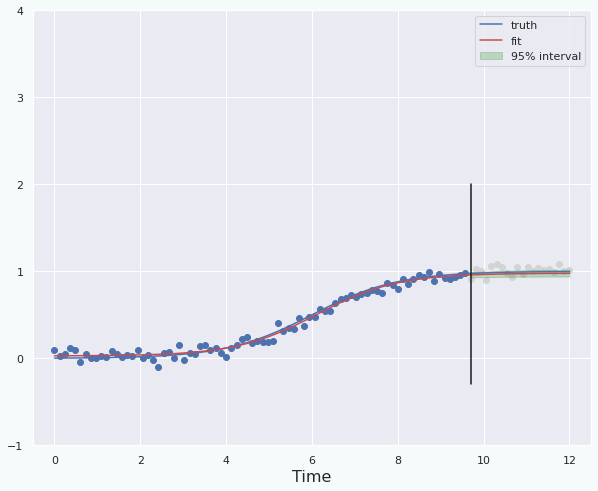

In [67]:
fig = plt.figure(figsize=(10,8))
fig.patch.set_facecolor('#f5fafa')
plt.axis([-0.5,12.5,-1,4])
plt.scatter(x[:length], ydat[:length])
plt.scatter(x[length:], ydat[length:], c='lightgrey')
plt.plot(x, sig(x), label='truth')
plt.plot(x,sig(x, fit_param['x']),'r',label = 'fit')
plt.fill_between(x[length:],values_LMH[:,0],values_LMH[:,2],color='green',alpha=0.2, label='95% interval')
#plt.plot(x[length:], values_LMH[:,1],c='m',label = 'median')
plt.plot([x[length],x[length]], [2,-0.3],'k')
plt.xlabel('Time', fontsize=16)
plt.legend(loc = 'best')
plt.savefig('./image_for_twitter/Boot-Percentile-{}.png'.format(length))

# Bootstrap-T interval

In [27]:
std = 0.05
x = np.linspace(0,12,100)
ydat=sig(x)+np.random.normal(scale=std,size=len(x))

length = 40
fit_param = curve_fit(sig, x[:length], ydat[:length], [1,1,6,0]) 

List_param = []
max_loop=1000
for i in range(max_loop):
    residues = np.random.choice(ydat[:length]-sig(x[:length],fit_param['x']),size=length)
    ysim = sig(x[:length],fit_param['x']) + residues
    fit_param_temp = curve_fit(sig, x[:length], ysim, [1,1,6,0])
    List_param.append(fit_param_temp['x'])
    
#Find the curves that will drow the 95% interval
k1 = int(0.025 * max_loop)
k2 = int(0.975 * max_loop)
List_values_all_sigs = np.array([sig(x[length:],param) for param in List_param])
t_stat = (List_values_all_sigs - sig(x[length:], fit_param['x']))/np.std(List_values_all_sigs, axis=0)

t_LMH = np.array([(np.partition(t_stat[:,i],k1)[k1-1],
               np.partition(t_stat[:,i],k2)[k2-1]) for i in range(len(x[length:]))])  #LMH stands for low median high

values_LMH = sig(x[length:], fit_param['x'])[:,None] - t_LMH*np.std(List_values_all_sigs, axis =0)[:,None]

#Find the curves that will drow the 95% interval
k1 = int(0.025 * max_loop)
k2 = int(0.975 * max_loop)
List_values_all_sigs = np.array([sig(x[length:],param) for param in List_param])
t_stat = (List_values_all_sigs - sig(x[length:], fit_param['x']))/np.std(List_values_all_sigs, axis=0)

t_LMH = np.array([(np.partition(t_stat[:,i],k1)[k1-1],
               np.partition(t_stat[:,i],k2)[k2-1]) for i in range(len(x[length:]))])  #LMH stands for low median high

values_LMH = sig(x[length:], fit_param['x'])[:,None] - t_LMH*np.std(List_values_all_sigs, axis =0)[:,None]

del List_values_all_sigs, t_LMH, t_stat  # free some memory

/home/jeremy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


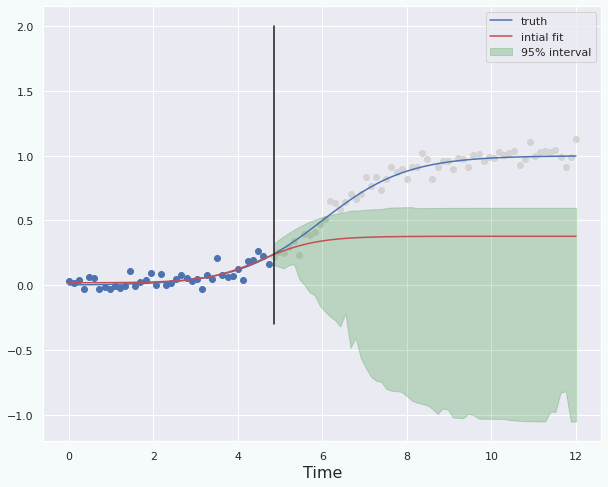

In [28]:
fig = plt.figure(figsize=(10,8))
fig.patch.set_facecolor('#f5fafa')
plt.scatter(x[:length], ydat[:length])
plt.scatter(x[length:], ydat[length:], c='lightgrey')
plt.plot(x, sig(x), label='truth')
plt.plot(x,sig(x, fit_param['x']),'r',label = 'intial fit')
plt.fill_between(x[length:],values_LMH[:,0],values_LMH[:,1],color='green',alpha=0.2, label='95% interval')
plt.plot([x[length],x[length]], [2,-0.3],'k')
plt.xlabel('Time', fontsize=16)
plt.legend(loc = 'best')
plt.savefig('Boot-T.png')

# Attempt in using McDiarmid inequality

In [73]:
std = 0.05
x = np.linspace(0,12,100)
ydat=sig(x)+np.random.normal(scale=std,size=len(x))

length = 40
fit_param = curve_fit(sig, x[:length], ydat[:length], [1,1,6,0]) 
std_est = np.sqrt(loss(ydat[:length],sig(x[:length],fit_param['x'])))     #estimates the std of the noise via the residuals

def determ_c(i,length=length, x=x, y=ydat, func=sig,fit_param=fit_param):
    k = 2
    Ytemp1 = func(x[:length],fit_param['x'])+k*std_est-(2*k*std_est*(np.arange(length)==i))
    Ytemp2 = func(x[:length],fit_param['x'])+k*std_est
    Ytemp3 = func(x[:length],fit_param['x'])-k*std_est+(2*k*std_est*(np.arange(length)==i))
    Ytemp4 = func(x[:length],fit_param['x'])-k*std_est
    diff1 = np.abs(curve_fit(func, x[:length], Ytemp1[:length], [1,1,6,0])['x'] - curve_fit(func, x[:length], Ytemp2[:length], [1,1,0,0])['x'])
    diff2 = np.abs(curve_fit(func, x[:length], Ytemp3[:length], [1,1,6,0])['x'] - curve_fit(func, x[:length], Ytemp4[:length], [1,1,0,0])['x'])
    return np.amax(np.array(list(diff1)+list(diff2)).reshape((2,diff2.size)),axis=0)
    
c = np.array([determ_c(i) for i in range(length)])

alpha = 0.95

# compute the alpha-confidence interval for each parameter: conf interval = parameter +- delta
delta = [np.sqrt(0.5*np.log(2/(1-alpha))*(c[:,i]**2).sum()) for i in range(fit_param['x'].size)]  #formula from McDiarmid inequaity

print(std_est)

/home/jeremy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


0.0432982699611324


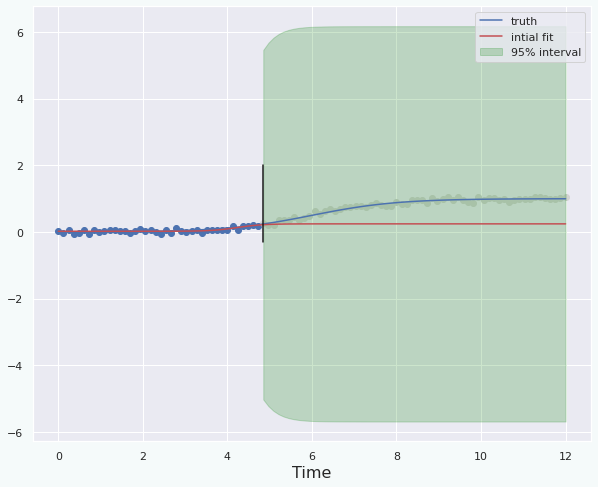

In [74]:
fig = plt.figure(figsize=(10,8))
fig.patch.set_facecolor('#f5fafa')
plt.scatter(x[:length], ydat[:length])
plt.scatter(x[length:], ydat[length:], c='lightgrey')
plt.plot(x, sig(x), label='truth')
plt.plot(x,sig(x, fit_param['x']),'r',label = 'intial fit')
param_max = fit_param['x']+np.array([delta[0],0,0,0])
param_min = fit_param['x']-np.array([delta[0],0,0,0])
plt.fill_between(x[length:],sig(x[length:],param_max),sig(x[length:],param_min),color='green',alpha=0.2, label='95% interval')
plt.plot([x[length],x[length]], [2,-0.3],'k')
plt.xlabel('Time', fontsize=16)
plt.legend(loc = 'best')
plt.savefig('McDiarmid.png')

# Putting the first bootstrap percentile & Boot-T on the same data

In [112]:
std = 0.05
x = np.linspace(0,12,100)
ydat=sig(x)+np.random.normal(scale=std,size=len(x))

length = 30
fit_param = curve_fit(sig, x[:length], ydat[:length], [1,1,6,0]) 

List_param = []
max_loop=1000
for i in range(max_loop):
    residues = np.random.choice(ydat[:length]-sig(x[:length],fit_param['x']),size=length)
    ysim = sig(x[:length],fit_param['x']) + residues
    fit_param_temp = curve_fit(sig, x[:length], ysim, [1,1,6,0])
    List_param.append(fit_param_temp['x'])
    
def bootT_interval(List_param):
    #Find the curves that will drow the 95% interval
    k1 = int(0.025 * max_loop)
    k2 = int(0.975 * max_loop)
    List_values_all_sigs = np.array([sig(x[length:],param) for param in List_param])
    t_stat = (List_values_all_sigs - sig(x[length:], fit_param['x']))/np.std(List_values_all_sigs, axis=0)

    t_LMH = np.array([(np.partition(t_stat[:,i],k1)[k1-1],
               np.partition(t_stat[:,i],k2)[k2-1]) for i in range(len(x[length:]))])  #LMH stands for low median high

    values_LMH = sig(x[length:], fit_param['x'])[:,None] - t_LMH*np.std(List_values_all_sigs, axis =0)[:,None]

    #Find the curves that will drow the 95% interval
    k1 = int(0.025 * max_loop)
    k2 = int(0.975 * max_loop)
    List_values_all_sigs = np.array([sig(x[length:],param) for param in List_param])
    t_stat = (List_values_all_sigs - sig(x[length:], fit_param['x']))/np.std(List_values_all_sigs, axis=0)

    t_LH = np.array([(np.partition(t_stat[:,i],k1)[k1-1],
               np.partition(t_stat[:,i],k2)[k2-1]) for i in range(len(x[length:]))])  #LH stands for low high

    values_LH = sig(x[length:], fit_param['x'])[:,None] - t_LMH*np.std(List_values_all_sigs, axis =0)[:,None]

    return values_LH

def perc_interval(List_param):
    #Find the curves that will drow the 95% interval
    k1 = int(0.025 * max_loop)
    k_med = int(0.5*max_loop)
    k2 = int(0.975 * max_loop)
    List_values_all_sigs = np.array([sig(x[length:],param) for param in List_param])
    values_LMMH = np.array([(np.partition(List_values_all_sigs[:,i],k1)[k1-1],
               np.partition(List_values_all_sigs[:,i],k_med)[k_med-1],
               List_values_all_sigs[:,i].mean(),
               np.partition(List_values_all_sigs[:,i],k2)[k2-1]) for i in range(len(x[length:]))])  #LMMH stands for low median mean high
    return values_LMMH


/home/jeremy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


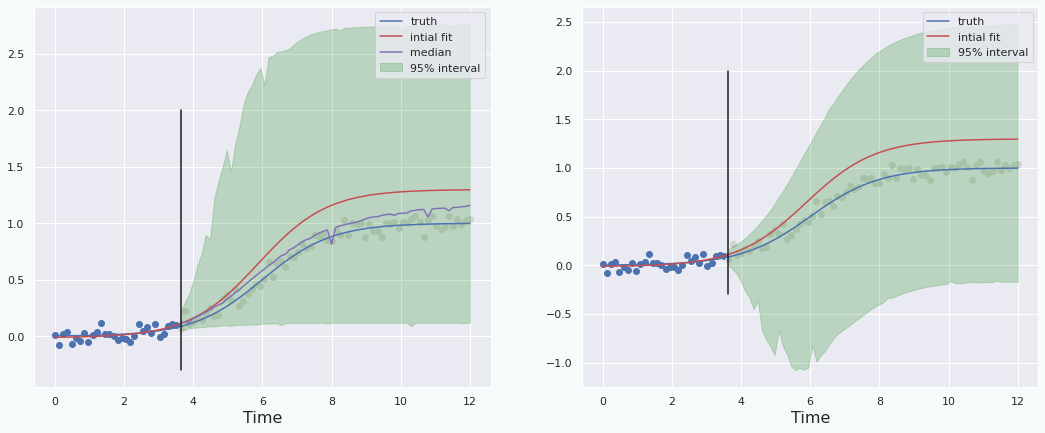

In [113]:
fig = plt.figure(figsize=(18,7))
fig.patch.set_facecolor('#f5fafa')

plt.subplot(1,2,1)
values_LMMH = perc_interval(List_param)
plt.scatter(x[:length], ydat[:length])
plt.scatter(x[length:], ydat[length:], c='lightgrey')
plt.plot(x, sig(x), label='truth')
plt.plot(x,sig(x, fit_param['x']),'r',label = 'intial fit')
plt.fill_between(x[length:],values_LMMH[:,0],values_LMMH[:,3],color='green',alpha=0.2, label='95% interval')
plt.plot(x[length:], values_LMMH[:,1],c='m',label = 'median')
#plt.plot(x[length:], values_LMMH[:,2],c='c',label = 'mean')
plt.plot([x[length],x[length]], [2,-0.3],'k')
plt.legend(loc = 'best')
plt.xlabel('Time', fontsize=16)

plt.subplot(1,2,2)
values_LH = bootT_interval(List_param)
plt.scatter(x[:length], ydat[:length])
plt.scatter(x[length:], ydat[length:], c='lightgrey')
plt.plot(x, sig(x), label='truth')
plt.plot(x,sig(x, fit_param['x']),'r',label = 'intial fit')
plt.plot([x[length],x[length]], [2,-0.3],'k')
plt.fill_between(x[length:],values_LH[:,0],values_LH[:,1],color='green',alpha=0.2, label='95% interval')
plt.legend(loc = 'best')
plt.xlabel('Time', fontsize=16)

plt.savefig('Comparison-{}.png'.format(length))
